# Maximizing Airport Efficiency
## A Discrete-Event Approach

The following is an annotation and description of the raw code and programmatical techniques used in the software used for this project. The following code is in the C# language, part of Microsoft's .NET framework. It is object-oriented, and follows a similar syntax to languages such as C, C++, and Java. 
The SimSharp library was used to handle the background work of the simulation. An open-source port of the popular SimPy framework for Python, SimSharp handles complex simulations very efficiently with simple syntax, while simultaneously allowing complex simulations to be built and run quickly. 

For information on Discrete-Event Simulations, see the *Methods (Algorithms and Implementation)* section of the research paper. To summarize the characteristics of a Discrete-Event Simulation:
- duration of events is randomized
- sequence of chronological events scheduled on a virtual timeline
- assumes the system is stagnant between events
- much more computationally efficient than a continuous simulation
SimSharp specifically uses a process-oriented approach: quoting the official repository, "Sim# is a process-based discrete event simulation framework. Models are defined by creating processes that interact with each other or with shared resources. Both processes and resources reference a common environment which also contains the simulation time, random number generators, and the event queue" ([abeham/SimSharp](https://github.com/abeham/SimSharp/blob/master/docs/README.md)).

The following is a class diagram of the code used for the simulation. There are three classes:
- Program: houses the Main() method that is run on program execution, and some utility methods for generating scenarios and handling data read/write
- Part: the class that holds the Part object and its associated properties and methods
- Plane: the class the holds the Plane object and its associated properties and methods
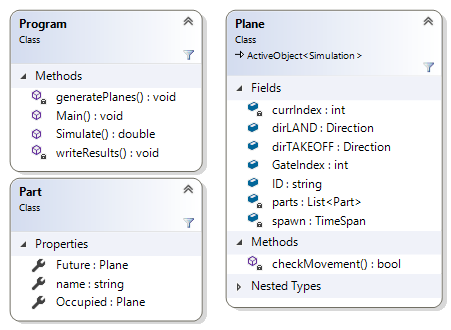


## Program.cs
The following are the instance variables defined in the Program class. Although it is not commonplace to define instance variables in the Program class of a C# project, it was the most efficient way of maintaining global variables across the multiple interacting classes involved in the simulation.
- algorithm - holds the enumerable type of the algorithm that the simulation is to run. The Algorithm type will be shown later.
- NUM_PLANES, NUM_GATES and NUM_TIMES - holds the number of planes and gates, and how many times the simulation should be run consecutively.
- SimTime - holds how long the simulation should be run, set to 10 hours by default.
- Gates, Taxiways & planes - these lists hold, respectively, the Gates, Taxiways, and Planes involved in the simulation. 
- North, Runway, & South - the simulation was run with one singular runway and a defined North and South off-ramp. The variation in airport size came only in the number of Gates.

In [ ]:
public class Program {
        private const Plane.Algorithm algorithm = Plane.Algorithm.FCFS;
        public static int NUM_GATES;
        public static int NUM_PLANES;
        public static double NUM_TIMES;
        public static readonly TimeSpan SimTime = TimeSpan.FromHours(10);
        public static List<Part> Gates = new List<Part>();
        public static List<Part> Taxiways = new List<Part>();
        private static List<Plane> planes = new List<Plane>();
        public static Part North = new Part("North Off-Ramp");
        public static Part Runway = new Part("Runway");
        public static Part South = new Part("South Off-Ramp");

The *Main()* method is run on program execution. This method runs 1000 simulations and writes the results of the simulations to a .csv file.

In [ ]:
    public static void Main(string[] args) {
            for (int j = 0; j < 1000; j++) { //simulate 1000 times
                double avg = 0;
                avg += Simulate(j, j);
                writeResults(avg);
            }
        }

The *Simulate()* method requires two parameters: rseed (the seed used to generate random numbers) and the iteration number.
The method first instantiates the variables defined above. Then, it creates a simulation, called *env*. It then reads the .csv (Comma Seperated Values) file associated with its iteration, and creates the planes defined in the .csv file. It also finds the number of gates that the given scenario requires, and instantiates the taxiways and gates needed. It then executes the simulation (*env.Run(SimTime)*), requiring merely one line of code! The method returns the latest time that a plane left the airport system in the simulation, which is used in data analysis.

In [ ]:
    public static double Simulate(int rseed, int iteration) {
            Gates = new List<Part>();
            North = new Part("North Off-Ramp");
            Runway = new Part("Runway");
            South = new Part("South Off-Ramp");
            Taxiways = new List<Part>();
            planes = new List<Plane>();


            DateTime start = new DateTime(2000, 1, 1);
            ThreadSafeSimulation env = new ThreadSafeSimulation(start, rseed);
            Console.WriteLine("\n\n== Airport ==");
            using (StreamReader reader = new StreamReader(@"scenarios\" + iteration + ".csv")) {
                reader.ReadLine(); //takes out first line
                while (!reader.EndOfStream) {
                    string[] props = reader.ReadLine().Split(',');
                    planes.Add(new Plane(env, ID: props[1], gate: Convert.ToInt32(props[2]), spawn: TimeSpan.FromMinutes(Convert.ToDouble(props[3])), algorithm));
                }
            }


            for (int i = 0; i <= planes.Max(p => p.GateIndex); i++) {
                Taxiways.Add(new Part("TS" + i));
                Gates.Add(new Part("Gate " + i));
            }

            env.Run(SimTime);

            return planes.Max(p => p.times[3]);
        }

The *generatePlanes* method has one parameter: the number of planes to generate. It generates, randomly, that number of planes and writes the data to the .csv file from which the previous method reads the scenarios.
The *writeResults* method simply takes a previously-calculated average processing time, combines that with details of the simulation that was just run, and writes that to a results.csv file. 

In [ ]:
    private static void generatePlanes(int number) {
            for (int i = 0; i < number; i++) {
                NUM_PLANES = new Random(i).Next(1, 25);
                NUM_GATES = new Random(i).Next(1, 10);
                using (var writer = new StreamWriter(System.IO.File.Create(@"scenarios\" + i + ".csv"))) {
                    writer.WriteLine("NUMBER,ID,GATE - 1 INDEX,SPAWNTIME(MIN)"); //header
                    for (int j = 0; j < NUM_PLANES; j++) {
                        String s = "";
                        s += j.ToString();
                        s += ",";
                        s += (char)(65 + (j % 26)) + j.ToString();
                        s += ",";
                        s += new Random(j).Next(1, NUM_GATES).ToString();
                        s += ",";
                        s += new Random(j).Next(1, number * 5).ToString();
                        writer.WriteLine(s);
                    }
                }
            }
        }

        private static void writeResults(double avg) {
            using (var writer = new StreamWriter(@"results.csv", true)) {
                writer.WriteLine(algorithm + "," + NUM_GATES + "," + NUM_PLANES + "," + avg);
            }
        }

## Part.cs
The following is the Part class, from which Part objects derive. The simulation harnesses a List of Parts to represent the whole airport, and a Part can be a Runway, a Taxiway, or a Gate.
Every part has the following attributes:
- a name
- an Occupied status, which holds the Plane that is currently on that Part, or Null if it is currently empty
- a Future status, which again holds a Plane or Null, and is used in the FWCHECK algorithm

In [ ]:
public class Part {
        public Part(string name) {
            this.name = name;
            Occupied = null;
            Future = null;
        }

        public string name { get; set; }
        public Plane Occupied { get; set; }
        public Plane Future { get; set; }

        public override string ToString() {
            if (Future == null) {
                return name + " ";
            } else {
                return name + "  " + Future.ID;
            }
        }
    }

## Plane.cs
The following are the instance variables of each Plane.
Direction and Algorithm are Enumerable types - meaning they can hold one of a defined set of values. For example, a variable of type Direction can only hold NORTH or SOUTH. 
- dirLAND and dirTAKEOFF variables hold, respectively, the direction from which to land or take off.
- Algorithm determines which algorithm to use when making decisions.
- GateIndex holds the index of the List of Parts which is the target Gate for this Plane.
- ID holds the ID name of this Plane
- times is an array of integers which holds the times of critical milestones of the Plane's route:
    - landing
    - gate arrival
    - gate departure
    - takeoff
- Process and Simulation are both datatypes provided by the SimSharp library and are used to allow SimSharp to run the simulation.
- spawn holds the time at which the Plane is set to spawn
- currIndex holds the current index of the Part on which the Plane is situated
- leave is a boolean that holds whether the Plane is on course towards the gate, or towards leaving the aiport
- left is a boolean that holds whether the Plane has taken off yet
- parts is a personal list of Parts that is unique to each Plane; it dictates the path of Parts the Plane needs to follow to reach its appropriate target: either its Gate to park or the runway in order to takeoff.

The *Plane()* method is simply the constructor of the object, which creates the Plane object when called and sets the instance variables to the desired attributes.

In [ ]:
public class Plane : ActiveObject<Simulation> {
        public enum Direction {
            NORTH,
            SOUTH
        }

        public enum Algorithm {
            FCFS,
            FWCHECK
        }
        
        public readonly Direction dirLAND;
        public readonly Direction dirTAKEOFF;
        public readonly Algorithm algorithm;
        public readonly int GateIndex;
        public readonly string ID;
        public int[] times = new int[4];

        private readonly Process Process;
        private Simulation simulation;
        private TimeSpan spawn;
        private int currIndex = -1;
        private bool leave;
        private bool left;
        private List<Part> parts;
    
        public Plane(ThreadSafeSimulation env, string ID, int gate, TimeSpan spawn, Algorithm algorithm) : base(env) {
            this.ID = ID;
            this.spawn = spawn;
            GateIndex = gate - 1;
            simulation = env;
            leave = false;
            this.algorithm = algorithm;
            if (GateIndex < Program.NUM_GATES / 2) {
                dirLAND = Direction.NORTH;
                dirTAKEOFF = Direction.SOUTH;
            } else {
                dirLAND = Direction.SOUTH;
                dirTAKEOFF = Direction.NORTH;
            }
            Process = env.Process(Moving());
        }

The following *makePartsList()* method simply calculates and creates the List of Parts that the Plane needs to follow. If *leave* is true, then it creates a path towards the runway. If not, it makes a path towards the Plane's targeted Gate. This method sets the parts List variable to the calculated path.

In [ ]:
    private void makePartsList() {
            parts = new List<Part>();
            if (leave) {
                if (dirTAKEOFF == Direction.NORTH) {
                    for (int i = GateIndex; i < Program.Taxiways.Count; i++) {
                        parts.Add(Program.Taxiways[i]);
                    }
                    parts.Add(Program.South);
                    parts.Add(Program.Runway);
                } else {
                    for (int i = GateIndex; i >= 0; i--) {
                        parts.Add(Program.Taxiways[i]);
                    }
                    parts.Add(Program.North);
                    parts.Add(Program.Runway);
                }
            } else
                if (dirLAND == Direction.NORTH) {
                parts.Add(Program.Runway);
                parts.Add(Program.South);
                for (int i = Program.Taxiways.Count - 1; i >= GateIndex; i--) {
                    parts.Add(Program.Taxiways[i]);
                }
                parts.Add(Program.Gates[GateIndex]);
            } else {
                parts.Add(Program.Runway);
                parts.Add(Program.South);
                for (int i = 0; i < GateIndex; i++) {
                    parts.Add(Program.Taxiways[i]);
                }
                parts.Add(Program.Gates[GateIndex]);
            }
        }

The following method is arguably the most important part -- it is where the algorithms are implemented. The *checkMovement()* method checks and return whether or not the Plane should move forward. If the FCFS algorithm is running, it checks the entire path in front of the Plane. The FWCHECK algorithm only checks the three Parts immediately in front of the Plane to see if they are either occupied, or allocated for the Future for another Plane.

In [ ]:
    private bool checkMovement() {
            if (algorithm.Equals(Algorithm.FCFS)) { //CHECKS THE ENTIRE PATH
                for (int i = currIndex; i < parts.Count; i++) {
                    if (parts[i].Occupied != this && parts[i].Occupied != null) {
                        return false;
                    }
                }
                return true;
            } else if (algorithm.Equals(Algorithm.FWCHECK)) {
                int check;
                if (currIndex + 3 > parts.Count) {
                    check = parts.Count;
                } else {
                    check = currIndex + 3;
                }

                for (int i = currIndex; i < check; i++) { //check the 3 in front
                    if (parts[i].Occupied != this && parts[i].Occupied != null) {
                        return false;
                    }
                    if (currIndex > 1 && parts[i].Future != this && parts[i].Future != null) {
                        return false;
                    }
                }

                return true;
            } else {
                return true;
            }
        }

The following *ChangePart()* method moves the Plane to the next part on its path, if it is safe.

In [ ]:
    private bool ChangePart() {
            if (currIndex > 0 && currIndex + 1 == parts.Count) { 
                if (!leave) { //if at gate
                    Program.Gates[GateIndex].Occupied = this; Program.Gates[GateIndex].Future = null;
                    return true;
                }
                parts[currIndex - 1].Occupied = null;
                currIndex = 0;
            } else {
                currIndex++;
                if (checkMovement()) {
                    //move to the next one, release from the last one
                    parts[currIndex].Occupied = null; parts[currIndex].Future = null;
                    if (parts.Count > currIndex + 1) { parts[currIndex + 1].Future = this; }
                    if (parts.Count > currIndex + 2) { parts[currIndex + 2].Future = this; }
                    if (parts.Count > currIndex + 3) { parts[currIndex + 3].Future = this; }
                    if (currIndex > 0) {
                        parts[currIndex - 1].Occupied = null;
                    }
                } else {
                    currIndex--;
                }
            }
            return false;
        }

The *Moving()* method is the primary method that is run during the simulation, it controls when the Plane should wait at the Gate, create its new Parts list, and eventually leave. 

In [ ]:
    private IEnumerable<Event> Moving() {
            while (true) {
                //simulation.Log(ID + " is running at " + simulation.Now);
                if ((spawn.Hours * 60 + spawn.Minutes) > simulation.NowD / 60) {
                    if(Program.Taxiways.Count > 0)
                        makePartsList();
                    yield return simulation.Timeout(TimeSpan.FromMinutes((spawn.Hours * 60 + spawn.Minutes) - simulation.NowD / 60));
                } else {
                    int oldIndex = currIndex;
                    if (!left) {
                        if (leave && currIndex + 1 == parts.Count) {
                            yield return simulation.Timeout(TimeSpan.FromMinutes(new Random().Next(2, 5)));
                            parts[currIndex].Occupied = null;
                            simulation.Log(ID + " has left at " + simulation.NowD / 60);
                            times[3] = simulation.NowD / 60;
                            left = true;
                            yield return simulation.TimeoutD(Program.SimTime.Hours - Environment.Now.Hour);
                        } else if (ChangePart()) { //if part is at GATE
                            times[1] = simulation.NowD / 60;
                            yield return simulation.Timeout(TimeSpan.FromMinutes(new Random().Next(15, 20)));
                            times[2] = simulation.NowD / 60;
                            leave = true;
                            Program.Gates[GateIndex].Occupied = null;
                            makePartsList();
                            currIndex = 0;
                        }
                        
                        yield return Environment.Timeout(TimeSpan.FromMinutes(new Random().Next(1, 3)));
                        if (times[0] == 0) { times[0] = simulation.NowD / 60; }
                    } else { break; }
                }
            }
    }